Let's load some libraries in order to build a GaussianNB as a benchmark

In [1]:
# Math stuff
import numpy as np
# For handling dataset
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# helping to remove outliers
from scipy.stats import iqr
# For undersampling
from imblearn.under_sampling import RandomUnderSampler
# metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# Model used as a benchmark
from sklearn.naive_bayes import GaussianNB

let's load the dataset and extract the V18, V13, V15 and the Class features

In [2]:
df = pd.read_csv('creditcard.csv')
df = df[['V18', 'V13', 'V15', 'Class']]

In [3]:
df.head()

,V18,V13,V15,Class
0,0.025791,-0.991390,1.468177,0
1,-0.183361,0.489095,0.635558,0
2,-0.121359,0.717293,2.345865,0
3,1.965775,0.507757,-0.631418,0
4,-0.038195,1.345852,0.175121,0


In [4]:
X = df.iloc[:,:].copy()

let's plot a boxplot and take a closer look at the distributions

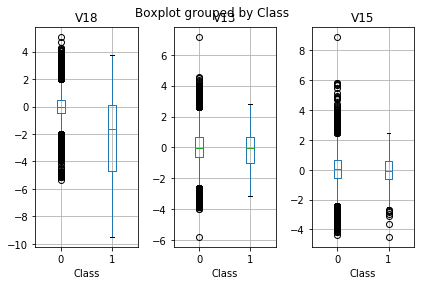

In [5]:
ax = plt.subplot(131)
X.boxplot('V18', 'Class', ax=ax)

ax = plt.subplot(132)
X.boxplot('V13', 'Class', ax=ax)

ax = plt.subplot(133)
X.boxplot('V15', 'Class', ax=ax)

plt.tight_layout()
plt.show()

by looking at the boxplot, we can see that there are a lot of outliers. <br />
this might be a problem, since the GaussianNB uses as a model a Gaussian distribution, the outliers might influence on the mean of the data, and the classifier might not perform very well.


for now, I'll compare the results of the classifier with the outliers and without the classifiers.

In [38]:
# separating the label from the dataset
X_new, y_new = X.iloc[:,:-1].copy(), X.iloc[:,-1].copy()

In [75]:
# taking a subsample
rus = RandomUnderSampler(ratio={0:246*30, 1:246}, random_state=0, return_indices=True)
X_resampled, y_resampled, idxes = rus.fit_sample(X_new, y_new)

print 'some indices: %s' % idxes[:5]
print 'total sample: %d' % len(y_resampled)

some indices: [266085 172120  15136  96393 208225]
total sample: 7626


In [40]:
# training the classifier
clf_with_outliers = GaussianNB()
clf_with_outliers.fit(X_resampled, y_resampled)

GaussianNB(priors=None)

In [41]:
# making predictions
y_pred = clf_with_outliers.predict(X_new.iloc[~idxes])

# checking results
precision, recall, _ = precision_recall_curve(y_pred, y_new.iloc[~idxes])
auc = average_precision_score(y_true=y_new.iloc[~idxes], y_score=y_pred)
print 'precision %.2f' % precision[1]
print 'recall %.2f' % recall[1]
print 'auc %.2f' % auc

precision 0.42
recall 0.17
auc 0.07


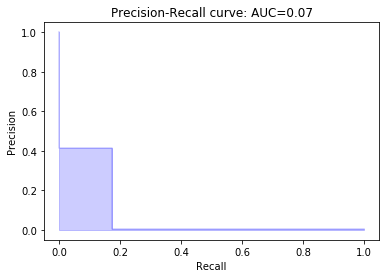

In [42]:
# code from scikit-learn
# ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(auc))
plt.show()

**The classifier didn't performe very well.**  <br />
This kind of classifiers isn't reliable to predict fraudulent transactions.

Now, let's take the outliers and see what happens...

In [43]:
# separating the legits from the fraudulents
# since the fraudulent ones are scarce, I'll keep them
isFraud = np.array(y_new==1, dtype=bool)
legit, fraud = X_new[~isFraud], X_new[isFraud]

In [44]:
# removing outliers from legit sample
for idx, feat in enumerate(legit.columns):
    q75, q25 = np.percentile(legit[feat], [75 ,25])
    iqr_ = iqr(legit[feat])*1.5
    
    greater = np.array(legit[feat] < q25 - iqr_, dtype=bool)
    legit.loc[greater, feat] = np.nan
    
    lower   = np.array(legit[feat] > q75 + iqr_, dtype=bool)
    legit.loc[lower, feat] = np.nan

C:\Users\rodrigo.silva\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\rodrigo.silva\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [45]:
legit = pd.concat([legit, fraud], axis=0)

In [46]:
legit = pd.concat([legit, y_new], axis=1)

In [47]:
legit = legit.dropna()

In [48]:
# checking if there is a missing value
legit.isnull().sum()

V18      0
V13      0
V15      0
Class    0
dtype: int64

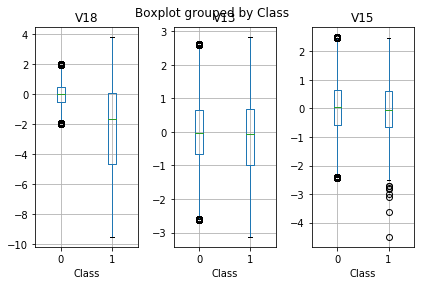

In [49]:
# plotting
ax = plt.subplot(131)
legit.boxplot('V18', 'Class', ax=ax)

ax = plt.subplot(132)
legit.boxplot('V13', 'Class', ax=ax)

ax = plt.subplot(133)
legit.boxplot('V15', 'Class', ax=ax)

plt.tight_layout()
plt.show()

In [50]:
len(X) - len(legit)

13343

We only removed 13343 samples. It's a small quantity if we look at the legit's quantity. <br />
Now, the outliers will no longer influence on the mean of the data. So, it might improve the performance.

In [67]:
# separating the label from the dataset
X_no_outliers, y_no_outliers = legit.iloc[:,:-1].copy(), legit.iloc[:,-1].copy()

In [76]:
X_resampled, y_resampled, idxes = rus.fit_sample(X_no_outliers, y_no_outliers)

In [61]:
clf_no_outliers = GaussianNB()
clf_no_outliers.fit(X_resampled, y_resampled)

GaussianNB(priors=None)

In [77]:
# making predictions
y_pred = clf_no_outliers.predict(X_no_outliers.iloc[~idxes])
y_true = y_no_outliers.iloc[~idxes]

# checking the results
precision, recall, _ = precision_recall_curve(y_pred, y_true)
auc = average_precision_score(y_true=y_true, y_score=y_pred)
print 'precision %.2f' % precision[1]
print 'recall %.2f' % recall[1]
print 'auc %.2f' % auc

precision 1.00
recall 0.00
auc 0.25


In [90]:
np.bincount(y_no_outliers.iloc[y_no_outliers.index.isin(idxes)])

array([7240,   12], dtype=int64)

In [79]:
from sklearn.metrics import confusion_matrix

In [81]:
print np.bincount(y_resampled)
np.bincount(y_no_outliers.iloc[~idxes])

[7380  246]


array([7614,   12], dtype=int64)

In [82]:
tn, fp, fn, tp = confusion_matrix(y_pred=y_pred, y_true=y_true).ravel()
confusion_matrix(y_pred=y_pred, y_true=y_true)

array([[7614,    0],
       [   9,    3]], dtype=int64)

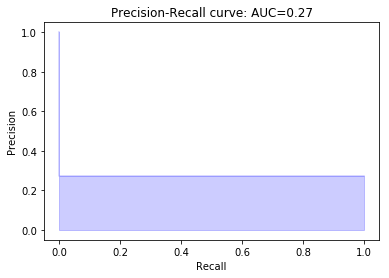

In [23]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(auc))
plt.show()

**Removing the outliers did improve the performance!** <br />
Compared to the first one, the precision improved a lot, however the recall didn't improve.

The auc improved from .08 to .27.

The classifier is still unreliable. Even if the classifier get right most of the predictions, it will miss the fraud ones with frequency.<br />
However, it's a good benchmark, so I'll stick with it.